In [1]:
import spacy
import textacy
#import textacy.preprocessing
import textacy.resources
#import textacy.keyterms
#import textacy.ke
#import neuralcoref
from spacy.symbols import ORTH, POS, NOUN, VERB,PRON
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt 
import spacy
import textacy
from nltk import sent_tokenize, word_tokenize, pos_tag
nlp = spacy.load("en_core_web_sm")
# from allennlp_models.pretrained import load_predictor
# predictor1 = load_predictor("glove-sst")
import seaborn as sns
import pandas as pd
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('D:/github/causal-graph-acquisition/SentiStrengthCom.jar')
senti.setSentiStrengthLanguageFolderPath('D:/github/causal-graph-acquisition/SentStrength_Data_Sept2011/')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from afinn import Afinn
afn = Afinn()
from pd_replicator import replicator
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer
lemma_function = WordNetLemmatizer()
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Read text file and preprocess.

### Without Neuralcoref

In [2]:
file_name = './Text/Causal Sentences.txt'
narrative = open(file_name, encoding="utf8").read()
narrative = narrative.lower()

#print('\nNLTK Sentences:\n')
raw_sentences = sent_tokenize(str(narrative))
print(len(raw_sentences))
# for sent in raw_sentences:
#     print(sent)
#     print()

380


# Extract the Subject-Verb-Object triples.

In [3]:
#new
finalList = []
sentences = []
ncl = []
nncl = [()]
checkPass = False
rootCheck = False
varForm1 = False
varForm2 = False
sub = ''
obj = ''
#tuple =('a','b','c')

#print(tuple[0])

for sent in raw_sentences:
    sent = nlp(sent)
    print("Sentence:")
    print(sent)
    
    print("Noun Chunks:")
    for nc in sent.noun_chunks:
        print (nc)
        ncl.append(nc)
    print ("Number of noun chunks: ", len(ncl))
    
    triplets = textacy.extract.subject_verb_object_triples(sent)
    triplets = list(triplets)
    if len(triplets) > 0:
        print("Triples from textacy:")
        for t in triplets:
            subject = t[0]
            objec = t[2]
            for chunk in ncl:
                for cToken in chunk:
                    if str(cToken) == str(t[0]):
                        subject = chunk
                    if str(cToken) == str(t[2]):
                        objec = chunk
            tup = (subject,t[1],objec)
            print(tup)
            finalList.append(tup)
            sentences.append(sent)
        if len(ncl) == 3:
            nncl = [(ncl[0],triplets[0][1],ncl[1])]
            nncl.append((ncl[0],triplets[0][1],ncl[2]))
            print("Triples other than textacy:")
            print(nncl[0])
            print(nncl[1])
            finalList.append(nncl[0])
            sentences.append(sent)
            finalList.append(nncl[1])
            sentences.append(sent)
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],triplets[0][1],ncl[1])]
#            print("Triples other than textacy:")
#            print(nncl[0])
#            finalList.append(nncl[0])
    else:
        print("Method from textacy; subject_verb_object_triples extracted nothing!")
        for token in sent:
            #print(token.text, token.dep_,)
            if token.dep_ == 'nsubj':
                sub = token
                #tuple[0] = str(token.text)
            elif token.dep_ == 'nsubjpass':
                checkPass = True
                sub = token
            elif token.dep_ == 'ROOT':
                #print("Heyyyyyyy")
                verb = token
                #print(verb)
                rootCheck = True
            elif token.pos_ == 'NOUN' and token.dep_ == 'conj':
                if rootCheck is True:
                    varForm2 = True
                else:
                    varForm1 = True
                #tuple[1] = token.text
            #elif token.dep_ == 'dobj':
            #    obj = token.text
                #tuple[2] = token.text
            #    break
            else:
                if token.dep_ == 'dobj':
                    obj = token
                    continue
                elif token.dep_ == 'pobj':
                    obj = token
                    continue
                
        for nChunk in ncl:
            for nToken in nChunk:
                if str(nToken) == str(sub):
                    sub = nChunk
                if str(nToken) == str(obj):
                    obj = nChunk
        if checkPass is True:
            tuple = (obj,verb,sub)
        else:
            tuple = (sub,verb,obj)
        print("Triple by combining nsubj, root and dobj:")
        print(tuple)
        finalList.append(tuple)
        sentences.append(sent)
        if len(ncl) == 3:
            if varForm1 == True:
                nncl = [(ncl[0],verb,ncl[2])]
                nncl.append((ncl[1],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
            else:
                nncl = [(ncl[0],verb,ncl[1])]
                nncl.append((ncl[0],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
            
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],verb,ncl[1])]
#            print("Triples other than sub, verb and obj:")
#            print(nncl[0])
#            finalList.append(nncl[0])

    ncl.clear()
    nncl.clear()
    rootCheck = False
    checkPass = False
    varForm1 = False
    varForm2 = False
    
trips = finalList

#        for token in nc:
#            print(token.text, token.dep_)

Sentence:
the company modernized its technology.
Noun Chunks:
the company
its technology
Number of noun chunks:  2
Triples from textacy:
(the company, modernized, its technology)
Sentence:
the singer released a single.
Noun Chunks:
the singer
a single
Number of noun chunks:  2
Triples from textacy:
(the singer, released, a single)
Sentence:
the doctor saved a life.
Noun Chunks:
the doctor
a life
Number of noun chunks:  2
Triples from textacy:
(the doctor, saved, a life)
Sentence:
the farmer harvested the wheat.
Noun Chunks:
the farmer
the wheat
Number of noun chunks:  2
Triples from textacy:
(the farmer, harvested, the wheat)
Sentence:
the artist painted a landscape.
Noun Chunks:
the artist
a landscape
Number of noun chunks:  2
Triples from textacy:
(the artist, painted, a landscape)
Sentence:
the dog chased its tail.
Noun Chunks:
the dog
its tail
Number of noun chunks:  2
Triples from textacy:
(the dog, chased, its tail)
Sentence:
the bird nested in the tree.
Noun Chunks:
the bird
the

Sentence:
the bird flew in the sky.
Noun Chunks:
the bird
the sky
Number of noun chunks:  2
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(the bird, flew, the sky)
Sentence:
the teacher graded the quizzes.
Noun Chunks:
the teacher
the quizzes
Number of noun chunks:  2
Triples from textacy:
(the teacher, graded, the quizzes)
Sentence:
the car broke down on the highway.
Noun Chunks:
the car
the highway
Number of noun chunks:  2
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(the car, broke, the highway)
Sentence:
the storm caused a flood.
Noun Chunks:
the storm
a flood
Number of noun chunks:  2
Triples from textacy:
(the storm, caused, a flood)
Sentence:
the baby slept through the night.
Noun Chunks:
the baby
the night
Number of noun chunks:  2
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(the baby,

Sentence:
the low level of public investment shows that no irrigation infrastructure exists.
Noun Chunks:
the low level
public investment
no irrigation infrastructure
Number of noun chunks:  3
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(no irrigation infrastructure, shows, public investment)
Triples other than sub, verb and obj:
(the low level, shows, public investment)
(the low level, shows, no irrigation infrastructure)
Sentence:
the low level of public investment shows that only 2 percent of south sudan's limited road network is paved.
Noun Chunks:
the low level
public investment
only 2 percent
south sudan's limited road network
Number of noun chunks:  4
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(south sudan's limited road network, shows, only 2 percent)
Sentence:
inadequate transportation infrastructure has resulted in less transport to markets.
Nou

Sentence:
the coaching refined their skills.
Noun Chunks:
the coaching
their skills
Number of noun chunks:  2
Triples from textacy:
(the coaching, refined, their skills)
Sentence:
the cheating scandal tarnished the institution.
Noun Chunks:
the cheating scandal
the institution
Number of noun chunks:  2
Triples from textacy:
(cheating scandal, tarnished, the institution)
Sentence:
the consistent practice honed his abilities.
Noun Chunks:
the consistent practice
his abilities
Number of noun chunks:  2
Triples from textacy:
(the consistent practice, honed, his abilities)
Sentence:
the broken ladder caused the accident.
Noun Chunks:
the broken ladder
the accident
Number of noun chunks:  2
Triples from textacy:
(the broken ladder, caused, the accident)
Sentence:
the intriguing plot captivated the readers.
Noun Chunks:
the intriguing plot
the readers
Number of noun chunks:  2
Triples from textacy:
(the intriguing plot, captivated, the readers)
Sentence:
the warm temperatures melted the snow 

Sentence:
the persistent effort yielded positive outcomes.
Noun Chunks:
the persistent effort
positive outcomes
Number of noun chunks:  2
Triples from textacy:
(the persistent effort, yielded, positive outcomes)
Sentence:
the unchecked pollution harmed the environment.
Noun Chunks:
the unchecked pollution
the environment
Number of noun chunks:  2
Triples from textacy:
(the unchecked pollution, harmed, the environment)
Sentence:
the sharp decline in sales worried the company.
Noun Chunks:
the sharp decline
sales
the company
Number of noun chunks:  3
Triples from textacy:
(the sharp decline, worried, the company)
Triples other than textacy:
(the sharp decline, worried, sales)
(the sharp decline, worried, the company)
Sentence:
the thorough planning averted potential issues.
Noun Chunks:
the thorough planning
potential issues
Number of noun chunks:  2
Triples from textacy:
(the thorough planning, averted, potential issues)
Sentence:
the strong winds damaged the roof.
Noun Chunks:
the stro

Sentence:
the proper wound dressing prevented complications.
Noun Chunks:
the proper wound
prevented complications
Number of noun chunks:  2
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(the occupational therapist, wound, prevented complications)
Sentence:
the medical team collaborated for optimal patient care.
Noun Chunks:
the medical team
optimal patient care
Number of noun chunks:  2
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(the medical team, collaborated, optimal patient care)
Sentence:
the heart monitor displayed irregular rhythms.
Noun Chunks:
the heart monitor
irregular rhythms
Number of noun chunks:  2
Triples from textacy:
(heart monitor, displayed, irregular rhythms)
Sentence:
the surgeon's precision minimized scarring.
Noun Chunks:
precision
Number of noun chunks:  1
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by

Sentence:
failing to follow instructions can cause errors in the final product.
Noun Chunks:
instructions
errors
the final product
Number of noun chunks:  3
Triples from textacy:
(failing, can cause, errors)
Triples other than textacy:
(instructions, can cause, errors)
(instructions, can cause, the final product)
Sentence:
the high humidity levels caused mold growth in the basement.
Noun Chunks:
the high humidity levels
mold growth
the basement
Number of noun chunks:  3
Triples from textacy:
(humidity levels, caused, mold growth)
Triples other than textacy:
(the high humidity levels, caused, mold growth)
(the high humidity levels, caused, the basement)
Sentence:
the excessive noise from construction caused sleep disturbances.
Noun Chunks:
the excessive noise
construction
sleep disturbances
Number of noun chunks:  3
Triples from textacy:
(the excessive noise, caused, sleep disturbances)
Triples other than textacy:
(the excessive noise, caused, construction)
(the excessive noise, caused,

Sentence:
the constant exposure to loud noise can cause hearing loss.
Noun Chunks:
the constant exposure
loud noise
loss
Number of noun chunks:  3
Triples from textacy:
(the constant exposure, can cause, hearing)
Triples other than textacy:
(the constant exposure, can cause, loud noise)
(the constant exposure, can cause, loss)
Sentence:
the misinformation spread on social media can cause panic.
Noun Chunks:
the misinformation
social media
panic
Number of noun chunks:  3
Method from textacy; subject_verb_object_triples extracted nothing!
Triple by combining nsubj, root and dobj:
(the misinformation, spread, panic)
Triples other than sub, verb and obj:
(the misinformation, spread, social media)
(the misinformation, spread, panic)
Sentence:
the excessive consumption of sugary foods can cause obesity.
Noun Chunks:
the excessive consumption
sugary foods
obesity
Number of noun chunks:  3
Triples from textacy:
(the excessive consumption, can cause, obesity)
Triples other than textacy:
(the ex

Sentence:
the excessive sugar intake can cause insulin resistance.
Noun Chunks:
the excessive sugar intake
insulin resistance
Number of noun chunks:  2
Triples from textacy:
(sugar intake, can cause, insulin resistance)
Sentence:
the absence of green spaces can cause stress in urban areas.
Noun Chunks:
the absence
green spaces
stress
urban areas
Number of noun chunks:  4
Triples from textacy:
(the absence, can cause, stress)
Sentence:
the incorrect calibration of instruments can cause measurement errors.
Noun Chunks:
the incorrect calibration
instruments
measurement errors
Number of noun chunks:  3
Triples from textacy:
(the incorrect calibration, can cause, measurement errors)
Triples other than textacy:
(the incorrect calibration, can cause, instruments)
(the incorrect calibration, can cause, measurement errors)
Sentence:
the improper disposal of waste can cause environmental pollution.
Noun Chunks:
the improper disposal
waste
environmental pollution
Number of noun chunks:  3
Triples

# Remove Duplicates from Triples

In [4]:
#causeffect = list(dict.fromkeys(causeffect))

print("Length of triples' List before removing duplicates:")
print(len(trips))

Triples = []
sentences1 = []

for sentence,ce in zip(sentences, trips):
    check = False
    #print("ce:")
    #print(ce)
    if len(Triples) == 0:
        #print("HEY!")
        Triples.append(ce)
        sentences1.append(sentence)
        #print("added!")
    else:
        for ct in Triples:
            #print("ct:")
            #print(ct)
            if str(ce[0]) == str(ct[0]) and str(ce[1]) == str(ct[1]) and str(ce[2]) == str(ct[2]):
                #print("duplicate")
                check = True
                break;
        if check == False:
            Triples.append(ce)
            sentences1.append(sentence)
            #print("added!")

print("\nList after removing duplicates:")
print(len(Triples))

Length of triples' List before removing duplicates:
561

List after removing duplicates:
487


# Filter correct triples from extracted triples

In [5]:
dagCauseTriples = []
dagcausalSentences = []

for sentence,line in zip(sentences1, Triples):
    taggedWords = []
    taggedWords1 = []
    check0 = False
    check2 = False
    #print(line)
    taggedWords = pos_tag(word_tokenize(str(line[0])))
    taggedWords1 = pos_tag(word_tokenize(str(line[2])))
    #print(taggedWords)
    #print(taggedWords1)
    for i in range(len(taggedWords)):
        if taggedWords[i][1] == 'NN' or taggedWords[i][1] == 'NNS':
            check0 = True
    for i in range(len(taggedWords1)):
        if taggedWords1[i][1] == 'NN' or taggedWords1[i][1] == 'NNS':
            check2 = True
    #print(check0)  
    #print(check2)
    if check0 == True and check2 == True:
        dagCauseTriples.append(line)
        dagcausalSentences.append(sentence)
    #print("**************************************************************************")
    
#for correctTriple in causalTriples:
#    print(correctTriple)

print(len(dagCauseTriples))

466


# Print the extracted triples with sentences and verbs.

In [6]:
dagCauseVerbs = []
for triple in dagCauseTriples:
    dagCauseVerbs.append(triple[1])

for sentence, triple, verb  in zip(dagcausalSentences, dagCauseTriples, dagCauseVerbs):
    print(sentence, triple, verb)
    print()

the company modernized its technology. (the company, modernized, its technology) modernized

the doctor saved a life. (the doctor, saved, a life) saved

the farmer harvested the wheat. (the farmer, harvested, the wheat) harvested

the artist painted a landscape. (the artist, painted, a landscape) painted

the dog chased its tail. (the dog, chased, its tail) chased

the bird nested in the tree. (the bird, nested, the tree) nested

the teacher planned the lesson. (the teacher, planned, the lesson) planned

the child played with friends. (the child, played, friends) played

the company invested in research. (the company, invested, research) invested

the band recorded a demo. (the band, recorded, a demo) recorded

the doctor referred the patient. (the doctor, referred, the patient) referred

the engineer tested the prototype. (the engineer, tested, the prototype) tested

the scientist published a paper. (the scientist, published, a paper) published

the worker installed the software. (the

# Causal Triples' Polarity (Whole) 

### [Pre-trained] Hugging face twitter-XLM-roBERTa-base

In [7]:
allen = []
for sent in dagCauseTriples:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
        # allen.append(-1)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
        # allen.append(1)
    else:
        # allen.append(scores[1])
        allen.append(0)

### [Afinn]

In [8]:
afinn = []
for sent in dagCauseTriples:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)

### [Vader]

In [9]:
vader = []

def vadersentimentanalysis(review):
    # negpos = []
    vs = analyzer.polarity_scores(review)
    return vs['compound']

    
for sent in dagCauseTriples:
    #print(sent)
    compound = vadersentimentanalysis(str(sent))
    # print(compound)
    compound = round(compound,3)
    vader.append(compound)
    # vader_analysis(compound)

### [SentiStrength]

In [10]:
sentiStrength = []

for sent in dagCauseTriples:
    #print(sent)
    result = senti.getSentiment(str(sent), score='scale')
    # print(result)
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)

### Data Frame (Causal Triples Whole)

In [11]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df_CTW = pd.DataFrame(list(zip(dagCauseTriples, allen, afinn, vader,sentiStrength)), columns =['Causal Triple', 'HuggingFace','Afinn','Vader','SentiStrength'])
# df2["Weight"] = round(df2.sum(axis=1)/4,3)
df_CTW["Weight"] = df_CTW.sum(axis=1)

for i in df_CTW.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CTW["HuggingFace"][i] != 0:
        count = count + 1
    if df_CTW["Afinn"][i] != 0:
        count = count + 1
    if df_CTW["Vader"][i] != 0:
        count = count + 1
    if df_CTW["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CTW["Weight"][i] = round(df_CTW["Weight"][i]/count,3)

sentPolarity = []
triplesWeight_sentLevel = []

for index, row in df_CTW.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    triplesWeight_sentLevel.append(tripleWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CTW["Polarity"] = sentPolarity
#df_CTW.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Causal Sentences' Polarity (Whole) 

### [Pre-trained] Hugging face twitter-XLM-roBERTa-base

In [12]:
def Allen_sents_SentLevel(causalSentences):
    allen = []
    for sent in causalSentences:
        encoded_input = tokenizer(str(sent), return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        if scores[0] > scores[1] and scores[0] > scores[2]:
            score = scores[0] * -1
            score = round(score,3)
            allen.append(score)
            # allen.append(-1)
        elif scores[2] > scores[1] and scores[2] > scores[0]:
            scores[2] = round(scores[2],3)
            allen.append(scores[2])
            # allen.append(1)
        else:
            # allen.append(scores[1])
            allen.append(0)
    return allen

### [Afinn]

In [13]:
def Afinn_sents_SentLevel(causalSentences):
    afinn = []
    for sent in causalSentences:
        #print(sent)
        score = afn.score(str(sent))
        #print(score)
        if score < -5:
            score = -5
        elif score > 5:
            score = 5
        score = score/5
        score = round(score,3)
        afinn.append(score)
    return afinn

### [Vader]

In [14]:
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']
    
def Vader_sents_SentLevel(causalSentences):
    vader = []
    for sent in causalSentences:
        #print(sent)
        #vaderTup = []
        compound = vadersentimentanalysis(str(sent))
        compound = round(compound,3)
        vader.append(compound)
        # res = vader_analysis(compound)
        #vaderTup.append(res)
        # vader.append(res)
    return vader

### [SentiStrength]

In [15]:
def Senti_sents_SentLevel(causalSentences):
    sentiStrength = []
    for sent in causalSentences:
        #print(sent)
        result = senti.getSentiment(str(sent), score='scale')
        #print(result)
        result = result[0]/4
        result = round(result,3)
        sentiStrength.append(result)
    return sentiStrength

In [16]:
dagCauseSents = dagcausalSentences
print(len(dagCauseSents))

466


### Data Frame (Causal Sentence at Sentence Level)

In [17]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

allen = Allen_sents_SentLevel(dagCauseSents)
afinn = Afinn_sents_SentLevel(dagCauseSents)
vader = Vader_sents_SentLevel(dagCauseSents)
sentiStrength = Senti_sents_SentLevel(dagCauseSents)

df_CSW = pd.DataFrame(list(zip(dagCauseSents, allen, afinn, vader,sentiStrength)), columns =['Causal Sentence', 'HuggingFace','Afinn','Vader','SentiStrength'])
# df2["Weight"] = round(df2.sum(axis=1)/4,3)

df_CSW["Weight"] = df_CSW.sum(axis=1)

for i in df_CSW.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CSW["HuggingFace"][i] != 0:
        count = count + 1
    if df_CSW["Afinn"][i] != 0:
        count = count + 1
    if df_CSW["Vader"][i] != 0:
        count = count + 1
    if df_CSW["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CSW["Weight"][i] = round(df_CSW["Weight"][i]/count,3)

sentPolarity = []
sentsWeight_sentLevel = []

for index, row in df_CSW.iterrows():
    sentWeightTuple = []
    weight = row['Weight']
    sentWeightTuple.append(weight)
    sentsWeight_sentLevel.append(sentWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CSW["Polarity"] = sentPolarity
#df_CSW.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Causal Triples' Polarity (Token Level) 

### [Pre-trained] Hugging face twitter-XLM-roBERTa-base

In [18]:
allen_word = []
allen_tuple = []

for tokenTuple in dagCauseTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        # print(token)
        encoded_input = tokenizer(str(token), return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        # print(scores)
        if scores[0] > scores[1] and scores[0] > scores[2]:
            score = scores[0] * -1
            score = round(score,3)
            allen_tuple.append(score)
            # allen_tuple.append(-1)
        elif scores[2] > scores[1] and scores[2] > scores[0]:
            scores[2] = round(scores[2],3)
            allen_tuple.append(scores[2])
            # allen_tuple.append(1)
        else:
            # allen_tuple.append(scores[1])
            allen_tuple.append(0)
    allen_word.append(allen_tuple)
    allen_tuple = []

### [Afinn] 

In [19]:
afinn_word = []
afinn_tuple = []

for tokenTuple in dagCauseTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) != ".": #or str(token) != ',' or str(token) != "-":
        #if str(token) not in marks:
            #print(token)
        score = afn.score(str(token))
        if score < -5:
            score = -5
        elif score > 5:
            score = 5
        score = score/5
        score = round(score,3)
        afinn_tuple.append(score)
        # if score > 0:
        #         #print('positive')
        #     afinn_tuple.append(1)
        # elif score < 0:
        #         #print('negative')
        #     afinn_tuple.append(-1)
        # else:
        #         #print('neutral')
        #     afinn_tuple.append(0)
    afinn_word.append(afinn_tuple)
    afinn_tuple = []

### [Vader] 

In [20]:
vader_word = []
vader_tuple = []

for tokenTuple in dagCauseTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) not in marks:
        vs = analyzer.polarity_scores(str(token))
        compound = vs['compound']
        compound = round(compound,3)
        vader_tuple.append(compound)
        # if compound >= 0.05:
        #     vader_tuple.append(1)   
        # elif compound <= -0.05 :
        #     vader_tuple.append(-1)
        # elif  compound > -0.05 and compound < 0.05:
        #     vader_tuple.append(0)
    vader_word.append(vader_tuple)
    vader_tuple = []

### [SentiStrength] 

In [21]:
senti_word = []
senti_tuple = []

for tokenTuple in dagCauseTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        #if str(token) not in marks:
        #print(token)
        result = senti.getSentiment(str(token), score='scale')
            #print(result)
        result = result[0]/4
        result = round(result,3)
        senti_tuple.append(result)
        # if result[0] > 0:
        #     senti_tuple.append(1)
        # elif result[0] < 0:
        #     senti_tuple.append(-1)
        # else:
        #     senti_tuple.append(0)
    senti_word.append(senti_tuple)
    senti_tuple = []

### Data Frame (Causal Triples Token Level)

In [22]:
#new

sum_list = []
sum_tup = []
limit= len(dagCauseTriples)

for i in range(0,limit):
    for j in range(0,len(allen_word[i])):
        count = 0
        if afinn_word[i][j] != 0: 
            count = count +1
        if vader_word[i][j] != 0:
            count = count +1
        if senti_word[i][j] != 0:
            count = count +1
        if allen_word[i][j] != 0:
            count = count +1
        if count == 0:
            count = 1
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        res = res/count
        res = round(res,3)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -1 and weight < -0.6:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -0.6 and weight < -0.3:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -0.3 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 1 and weight > 0.6:
                tokenPolarity.append('Strong Positive')
            elif weight <= 0.6 and weight > 0.3:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 0.3 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

triplesWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight, 3)
    if tripleWeight > 1: 
        tripleWeight = 1
    if tripleWeight < -1:
        tripleWeight = -1
    weightSumTup.append(tripleWeight)
    triplesWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

triplePolarity_list = DetectPolarity(triplesWeight_TokenLevel)

token_list = []
for i in dagCauseTriples:
    dummy = []
    for j in i:
        dummy.append(str(j))
    token_list.append(dummy)
    
df1 = pd.DataFrame(list(zip(dagCauseTriples,token_list, allen_word, afinn_word,vader_word,senti_word,sum_list,tokenPolarity_list,triplesWeight_TokenLevel, triplePolarity_list)), 
                      columns =['Causal Triple', "Tokens", 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Triple Weight','Triple Polarity'])

# df1 = df1.explode(['Tokens', 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight', 'Token Polarity'], ignore_index=False)
df1 = df1.explode(['Tokens', 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight', 'Token Polarity'], ignore_index=False)

prev = -1
for index, row in df1.iterrows():
    if prev == index:
        row['Causal Triple'] = ""
        row['Triple Weight'] = ""
        row['Triple Polarity'] = ""
    prev = index
#df1.style

In [23]:
triplesPolarity_list = []
tripleWeight_TokenLevel = []
for i,j in zip(triplesWeight_TokenLevel,triplePolarity_list):
    tripleWeight_TokenLevel.append(i[0])
    triplesPolarity_list.append(j[0]) 
    
df_CTT = pd.DataFrame(list(zip(tripleWeight_TokenLevel, triplesPolarity_list)), columns =['Weight','Polarity'])
df_CTT.style

,Weight,Polarity
0,0.400000,Moderate Positive
1,0.363000,Moderate Positive
2,0.000000,Neutral
3,0.000000,Neutral
4,-0.250000,Weak Negative
5,0.000000,Neutral
6,0.000000,Neutral
7,0.703000,Strong Positive
8,0.000000,Neutral
9,0.000000,Neutral


# Causal Sentences' Polarity (Token Level) 

### Generating list of tokens without stop words and punctuation marks.

In [24]:
def GenerateTokens(causalSentences):
    marks = ['.',',','(',')','-',':',';','/',"'s",'_','__','--','"', '’', '—']
    tagsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    token_list = []
   
    for sent in causalSentences:
        tokens = word_tokenize(str(sent))
        tags = pos_tag(tokens)
        token_tuple = []
        for token,tag in tags:
            if str(token) not in marks:
                if str(token) not in stopwords.words() or tag in tagsList:
                    token_tuple.append(str(token))
        token_list.append(token_tuple)
    return token_list

### [Pre-trained] Hugging face twitter-XLM-roBERTa-base

In [25]:
def Allen_sents_TokenLevel(token_list):
    allen_word = []
    allen_tuple = []
    for tokenTuple in token_list:
        # print(tokenTuple)
        for token in tokenTuple:
            # print(token)
            encoded_input = tokenizer(str(token), return_tensors='pt')
            output = model(**encoded_input)
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            if scores[0] > scores[1] and scores[0] > scores[2]:
                score = scores[0] * -1
                score = round(score,3)
                allen_tuple.append(score)
            elif scores[2] > scores[1] and scores[2] > scores[0]:
                scores[2] = round(scores[2],3)
                allen_tuple.append(scores[2])
            else:
                # allen_tuple.append(scores[1])
                allen_tuple.append(0)
        allen_word.append(allen_tuple)
        allen_tuple = []
    return allen_word

### [Afinn] 

In [26]:
def Afinn_sents_TokenLevel(token_list):
    afinn_word = []
    afinn_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            score = afn.score(str(token))
            if score < -5:
                score = -5
            elif score > 5:
                score = 5
            score = score/5
            score = round(score,3)
            afinn_tuple.append(score)
        afinn_word.append(afinn_tuple)
        afinn_tuple = []
    return afinn_word

### [Vader] 

In [27]:
def Vader_sents_TokenLevel(token_list):
    vader_word = []
    vader_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
            vs = analyzer.polarity_scores(str(token))
            compound = vs['compound']
            compound = round(compound,3)
            vader_tuple.append(compound)
        vader_word.append(vader_tuple)
        vader_tuple = []
    return vader_word

### [SentiStrength] 

In [28]:
def Senti_sents_TokenLevel(token_list):
    senti_word = []
    senti_tuple = []
    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
                #print(token)
            result = senti.getSentiment(str(token), score='scale')
                #print(result)
            result = result[0]/4
            result = round(result,3)
            senti_tuple.append(result)
        senti_word.append(senti_tuple)
        senti_tuple = []
    return senti_word

### Data Frame (Causal Sentences Word Level)

In [29]:
#new

token_list = GenerateTokens(dagCauseSents)
allen_word = Allen_sents_TokenLevel(token_list)
afinn_word = Afinn_sents_TokenLevel(token_list)
vader_word = Vader_sents_TokenLevel(token_list)   
senti_word = Senti_sents_TokenLevel(token_list)

sum_list = []
sum_tup = []
limit= len(dagCauseSents)

for i in range(0,limit):
    for j in range(0,len(allen_word[i])):
        count = 0
        if afinn_word[i][j] != 0: 
            count = count +1
        if vader_word[i][j] != 0:
            count = count +1
        if senti_word[i][j] != 0:
            count = count +1
        if allen_word[i][j] != 0:
            count = count +1
        if count == 0:
            count = 1
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        res = res/count
        res = round(res,3)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -1 and weight < -0.6:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -0.6 and weight < -0.3:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -0.3 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 1 and weight > 0.6:
                tokenPolarity.append('Strong Positive')
            elif weight <= 0.6 and weight > 0.3:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 0.3 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

sentsWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = 0
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight, 3)
    if tripleWeight > 1: 
        tripleWeight = 1
    if tripleWeight < -1:
        tripleWeight = -1
    weightSumTup.append(tripleWeight)
    sentsWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

SentencePolarity_list = DetectPolarity(sentsWeight_TokenLevel)

    
df1 = pd.DataFrame(list(zip(dagCauseSents,token_list, allen_word, afinn_word,vader_word,senti_word,sum_list,tokenPolarity_list,sentsWeight_TokenLevel,SentencePolarity_list)), 
                      columns =['Causal Sentence', "Tokens", 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Sentence Weight','Sentence Polarity'])

df1 = df1.explode(['Tokens', 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight', 'Token Polarity'], ignore_index=False)

prev = -1
for index, row in df1.iterrows():
    if prev == index:
        row['Causal Sentence'] = ""
        row['Sentence Weight'] = ""
        row['Sentence Polarity'] = ""
    prev = index
#df1.style

In [30]:
sentencePolarity_list = []
sentWeight_TokenLevel = []
for i,j in zip (sentsWeight_TokenLevel,SentencePolarity_list):
    sentWeight_TokenLevel.append(i[0]) 
    sentencePolarity_list.append(j[0]) 
    
df_CST = pd.DataFrame(list(zip(sentWeight_TokenLevel, sentencePolarity_list)), columns =['Weight','Polarity'])
df_CST.style

,Weight,Polarity
0,0.400000,Moderate Positive
1,0.363000,Moderate Positive
2,0.000000,Neutral
3,0.000000,Neutral
4,-0.250000,Weak Negative
5,0.000000,Neutral
6,-0.423000,Moderate Negative
7,0.703000,Strong Positive
8,0.000000,Neutral
9,0.000000,Neutral


# Causal Verbs Polarity (Whole) 

### [Pre-trained] Hugging face twitter-XLM-roBERTa-base

In [31]:
allen = []
for sent in dagCauseVerbs:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
    else:
        # allen.append(scores[1])
        allen.append(0)

### [Afinn]

In [32]:
afinn = []
for sent in dagCauseVerbs:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)

### [Vader]

In [33]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
    
for sent in dagCauseVerbs:
    compound = vadersentimentanalysis(str(sent))
    compound = round(compound,3)
    compound = round(compound,3)
    vader.append(compound)

### [SentiStrength]

In [34]:
sentiStrength = []

for sent in dagCauseVerbs:
    result = senti.getSentiment(str(sent), score='scale')
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)

### Data Frame (Causal Verbs Whole)

In [35]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df_CVW = pd.DataFrame(list(zip(dagCauseVerbs, allen, afinn, vader,sentiStrength)), columns =['Causal Verb', 'HuggingFace','Afinn','Vader','SentiStrength'])
# df2["Weight"] = round(df2.sum(axis=1)/4,3)

df_CVW["Weight"] = df_CVW.sum(axis=1)

for i in df_CVW.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CVW["HuggingFace"][i] != 0:
        count = count + 1
    if df_CVW["Afinn"][i] != 0:
        count = count + 1
    if df_CVW["Vader"][i] != 0:
        count = count + 1
    if df_CVW["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CVW["Weight"][i] = round(df_CVW["Weight"][i]/count,3)

sentPolarity = []
VerbsWeight_sentLevel = []

for index, row in df_CVW.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    VerbsWeight_sentLevel.append(tripleWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CVW["Polarity"] = sentPolarity
#df_CVW.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Lemma Causal Verbs Polarity (Whole) 

### Generating list of lemmas for whole causal verbs.

In [37]:
lemmaDagCauseVerbs = []
tagsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
for verb in dagCauseVerbs:
    #print("Verb:" + verb)
    tokens = word_tokenize(str(verb))
    #print("Tokens:" + str(tokens))
    tags = pos_tag(tokens)
    #print(tags)
    for token,tag in tags:
        #print("Token:" + token)
        #print("Tag:" + tag)
        if token not in stopwords.words() or tag in tagsList:
            #print("No stop:" + token)
            lemma = lemma_function.lemmatize(str(token))
            #print("Lemma:" + lemma)
            lemmaDagCauseVerbs.append(lemma)

### [Pre-trained] Hugging face twitter-XLM-roBERTa-base

In [38]:
allen = []
for sent in lemmaDagCauseVerbs:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
    else:
        # allen.append(scores[1])
        allen.append(0)

### [Afinn]

In [39]:
afinn = []
for sent in lemmaDagCauseVerbs:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)

### [Vader] 

In [40]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
    
for sent in lemmaDagCauseVerbs:
    compound = vadersentimentanalysis(str(sent))
    compound = round(compound,3)
    vader.append(compound)

### [SentiStrength] 

In [41]:
sentiStrength = []

for sent in lemmaDagCauseVerbs:
    result = senti.getSentiment(str(sent), score='scale')
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)

### Data Frame (Lemma Causal Verbs Whole)

In [42]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df_CVL = pd.DataFrame(list(zip(dagCauseVerbs, lemmaDagCauseVerbs,allen, afinn, vader,sentiStrength)), columns =['Causal Verb', 'Lemma(Causal Verb)' ,'HuggingFace','Afinn','Vader','SentiStrength'])
# df2["Weight"] = round(df2.sum(axis=1)/4,3)

df_CVL["Weight"] = df_CVL.sum(axis=1)

for i in df_CVL.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CVL["HuggingFace"][i] != 0:
        count = count + 1
    if df_CVL["Afinn"][i] != 0:
        count = count + 1
    if df_CVL["Vader"][i] != 0:
        count = count + 1
    if df_CVL["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CVL["Weight"][i] = round(df_CVL["Weight"][i]/count,3)

sentPolarity = []
LemmaVerbsWeight_tokLevel = []

for index, row in df_CVL.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    LemmaVerbsWeight_tokLevel.append(tripleWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CVL["Polarity"] = sentPolarity
#df_CVL.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Stem Causal Verbs Polarity (Whole) 

### Generating list of stems for whole causal verbs.

In [44]:
stemDagCauseVerbs = []
tagsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
for verb in dagCauseVerbs:
    # print("Verb:" + verb)
    tokens = word_tokenize(str(verb))
    # print("Tokens:" + str(tokens))
    tags = pos_tag(tokens)
    # print(tags)
    for token,tag in tags:
        if token not in stopwords.words() or tag in tagsList:
            # print("Token:" + token)
            stem = ps.stem(token)
            # print("Lemma:" + lemma)
            stemDagCauseVerbs.append(stem)

### [Pre-trained] Hugging face twitter-XLM-roBERTa-base

In [45]:
allen = []
for sent in stemDagCauseVerbs:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
    else:
        # allen.append(scores[1])
        allen.append(0)

### [Afinn]

In [46]:
afinn = []
for sent in stemDagCauseVerbs:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)

### [Vader] 

In [47]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
    
for sent in stemDagCauseVerbs:
    compound = vadersentimentanalysis(str(sent))
    compound = round(compound,3)
    vader.append(compound)

### [SentiStrength] 

In [48]:
sentiStrength = []

for sent in stemDagCauseVerbs:
    result = senti.getSentiment(str(sent), score='scale')
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)

### Data Frame (Stem Causal Verbs Whole)

In [49]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df_CVS = pd.DataFrame(list(zip(dagCauseVerbs, stemDagCauseVerbs, allen, afinn, vader,sentiStrength)), columns =['Causal Verb', 'Stem(Causal Verb)' ,'HuggingFace','Afinn','Vader','SentiStrength'])
# df2["Weight"] = round(df2.sum(axis=1)/4,3)

df_CVS["Weight"] = df_CVS.sum(axis=1)

for i in df_CVS.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CVS["HuggingFace"][i] != 0:
        count = count + 1
    if df_CVS["Afinn"][i] != 0:
        count = count + 1
    if df_CVS["Vader"][i] != 0:
        count = count + 1
    if df_CVS["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CVS["Weight"][i] = round(df_CVS["Weight"][i]/count,3)

sentPolarity = []
StemVerbsWeight_tokLevel = []

for index, row in df_CVS.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    StemVerbsWeight_tokLevel.append(tripleWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CVS["Polarity"] = sentPolarity
#df_CVS.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Overall Polarity of Sents and Triples by all Seven Methods

In [50]:
#totalWeight_AllMethods = []

limit= len(dagCauseSents)

# for i in range(0,limit):
#     #dataframe_WordLevel(i)
#     #print(len(allen_word[i]))
#     sum_tup = []
#     for j in range(0,len(sentsWeight_sentLevel[i])):
#         res = sentsWeight_sentLevel[i][j]+triplesWeight_sentLevel[i][j]+sentsWeight_TokenLevel[i][j]+triplesWeight_TokenLevel[i][j]+VerbsWeight_sentLevel[i][j]
#         #print(res)
#         res = round(res/7,2)
#         sum_tup.append(res)
#     totalWeight_AllMethods.append(sum_tup)
    
# totalPlarity_AllMethods = DetectPolarity(totalWeight_AllMethods)

# df_AllMethods = pd.DataFrame(list(zip(dagCauseSents, dagCauseTriples, dagCauseVerbs,lemmaDagCauseVerbs,stemDagCauseVerbs,sentsWeight_sentLevel, triplesWeight_sentLevel, sentsWeight_TokenLevel, triplesWeight_TokenLevel, VerbsWeight_sentLevel ,LemmaVerbsWeight_tokLevel,StemVerbsWeight_tokLevel,totalWeight_AllMethods,totalPlarity_AllMethods)), 
#                              columns =['Causal Sentence', 'Causal Triple','Causal Verb', 'Lemma(Causal Verb)', 'Stem(Causal Verb)','Method1 (Sent_Whole)', 'Method2 (Trip_Whole)','Method3 (Sent_TokLevel)','Method4 (Trip_TokLevel)','Method5 (Verb_Whole)','Method6 (Lemma_Verb)','Method7 (Stem_Verb)','Total Weight','Overall Polarity'])

df_AllMethods = pd.DataFrame(list(zip(sentsWeight_sentLevel, triplesWeight_sentLevel, sentsWeight_TokenLevel, triplesWeight_TokenLevel, VerbsWeight_sentLevel, LemmaVerbsWeight_tokLevel,StemVerbsWeight_tokLevel)), 
                             columns =['Method1 (Sent_Whole)', 'Method2 (Trip_Whole)','Method3 (Sent_TokLevel)','Method4 (Trip_TokLevel)','Method5 (Verb_Whole)','Method6 (Lemma_Verb)','Method7 (Stem_Verb)'])

# df_AllMethods.style

In [51]:
Method1 = []
Method2 = []
Method3 = []
Method4 = []
Method5 = []
Method6 = []
Method7 = []

for index, row in df_AllMethods.iterrows():
    Method1.append(row['Method1 (Sent_Whole)'][0])
    Method2.append(row['Method2 (Trip_Whole)'][0])
    Method3.append(row['Method3 (Sent_TokLevel)'][0])
    Method4.append(row['Method4 (Trip_TokLevel)'][0])
    Method5.append(row['Method5 (Verb_Whole)'][0])
    Method6.append(row['Method6 (Lemma_Verb)'][0])
    Method7.append(row['Method7 (Stem_Verb)'][0])

In [52]:
df_new = pd.DataFrame()
df_new['Strategy1'] = Method1
df_new['Strategy2'] = Method3
df_new['Strategy3'] = Method2
df_new['Strategy4'] = Method4
df_new['Strategy5'] = Method5
df_new['Strategy6'] = Method6
df_new['Strategy7'] = Method7
# df_new.style

In [53]:
df_new.to_excel("Causal Strengths from All Strategies.xlsx")  

<AxesSubplot:>

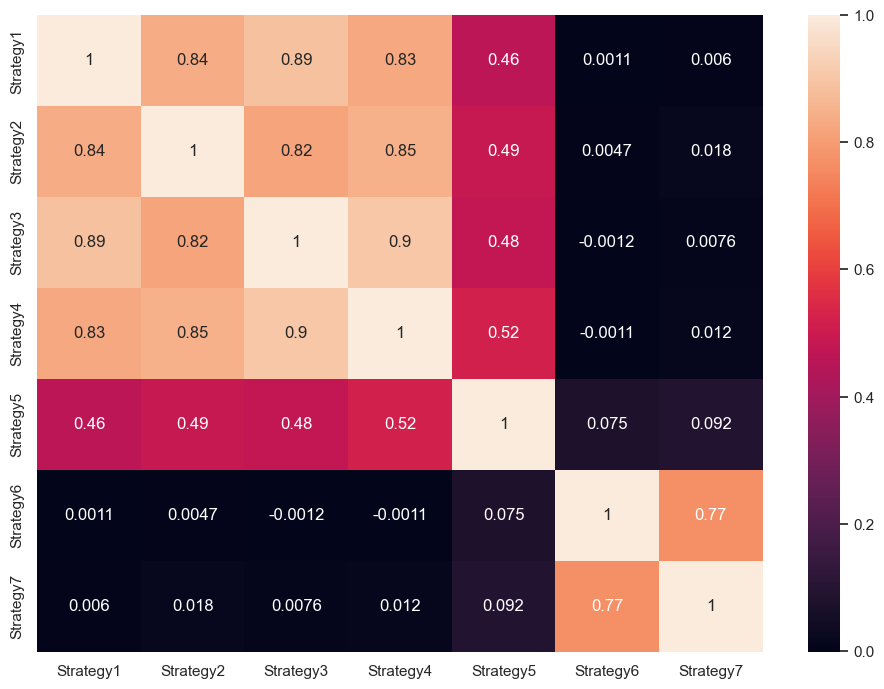

In [54]:
corr_matrix = df_new.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data=corr_matrix, annot=True)

In [55]:
corr_matrix

,Strategy1,Strategy2,Strategy3,Strategy4,Strategy5,Strategy6,Strategy7
Strategy1,1.000000,0.838831,0.886853,0.829223,0.460975,0.001100,0.005957
Strategy2,0.838831,1.000000,0.817775,0.849377,0.490715,0.004719,0.017713
Strategy3,0.886853,0.817775,1.000000,0.902526,0.477085,-0.001246,0.007642
Strategy4,0.829223,0.849377,0.902526,1.000000,0.522529,-0.001109,0.011635
Strategy5,0.460975,0.490715,0.477085,0.522529,1.000000,0.075088,0.092235
Strategy6,0.001100,0.004719,-0.001246,-0.001109,0.075088,1.000000,0.766620
Strategy7,0.005957,0.017713,0.007642,0.011635,0.092235,0.766620,1.000000
